In [1]:
import torch
from torch import sqrt
import torch.nn as nn
import torch.optim as optim

import math

import matplotlib.pyplot as plt

from copy import copy
from itertools import product
from tqdm import tqdm

import seaborn as sns

import pickle
import os

import pandas as pd
import numpy as np

# **Data and model**

In [2]:
def uniform_over_sphere(samples, n):
  X = torch.randn(samples, n)
  return torch.nn.functional.normalize(X, dim=1)

def training_data(n, input_dim, gamma, k=0):
  '''
  Returns a training batch of size 2n. 
  Positive points are positions 0 through n-1
  Negative points are positions n through 2n-1
  The k corruptions are at indices 0 through k-1 and n through n+k-1
  '''
  samples = 2*n
  X = torch.zeros(samples, input_dim)
  X[:n, 0] = +1 * sqrt(torch.tensor(gamma))
  X[n:, 0] = -1 * sqrt(torch.tensor(gamma))
  X[:, 1:] = sqrt(torch.tensor(1-gamma)) * uniform_over_sphere(samples, input_dim-1)

  y = torch.zeros(samples,1)
  y[:n,0] = +1
  y[n:,0] = -1

  #add corruptions to labels
  y[0:k,0]   = -1
  y[n:n+k,0] = +1


  corrupt_indices = list(range(0,k)) + list(range(n,n+k))
  clean_indices = list(range(k,n)) + list(range(n+k, 2*n))

  return X, y, clean_indices, corrupt_indices

In [3]:
class TwoLayerNet(nn.Module):
    def __init__(self, input_size, hidden_size):

        OUTPUT_SIZE = 1

        super(TwoLayerNet, self).__init__()
        self.fc1 = nn.Linear(in_features=input_size, out_features=hidden_size, bias = False)
        #self.fc2.weight.data = lambda_w * torch.randn_like(self.fc2.weight.data) / sqrt()


        self.fc2 = nn.Linear(in_features=hidden_size, out_features=OUTPUT_SIZE, bias=False)
        self.fc2.weight.data[:, :hidden_size//2] = 1.0  # set half the weights to +1 and -1
        self.fc2.weight.data[:, hidden_size//2:] = -1.0
        self.fc2.weight.requires_grad = False  # set fc2 weights to not trainable

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

def hinge_loss(f_out, y):
  n = torch.numel(y)
  return (1/n)*torch.sum(torch.relu(1 - y*f_out))

def logistic_loss(f_out, y):
  n = torch.numel(y)
  return (1/n)*torch.sum(torch.log(1 + torch.exp(-f_out*y)))

In [4]:
def num_correctly_classified(model_out, y):
  return sum(torch.sign(model_out) == torch.sign(y)).item()

def num_fully_fitted(model_out, y):
  '''Assuming hinge loss'''
  return sum(y*model_out >= 1).item()


def experiment(input_size, hidden_size, n, k, gamma, step_size, epochs, criterion, compute_test_losses=False):

  X, y, clean_indices, corrupt_indices = training_data(n=n, input_dim=input_size, gamma=gamma, k=k)

  test_size = 10000
  X_test, y_test, _, _ = training_data(n=test_size, input_dim=input_size, gamma=gamma, k=0)

  model = TwoLayerNet(input_size=input_size, hidden_size=hidden_size)

  optimizer = optim.SGD(model.parameters(), lr=step_size)

  fully_fitted_frac = []
  correctly_classified_frac = []
  correctly_classified_clean_frac = []
  correctly_classified_corrupt_frac = []
  total_loss = []
  clean_loss = []
  corrupt_loss = []
  test_losses = []
  test_correctly_classified_frac = []

  for epoch in tqdm(range(epochs)):

    optimizer.zero_grad()
    outputs = model(X)
    loss = criterion(outputs,y)
    loss.backward()
    optimizer.step()

    with torch.no_grad():
      fully_fitted_frac.append(num_fully_fitted(outputs, y)/n)

      correctly_classified_frac.append(num_correctly_classified(outputs, y)/n)
      correctly_classified_clean_frac.append(num_correctly_classified(outputs[clean_indices,:], y[clean_indices,:])/(n-k))
      correctly_classified_corrupt_frac.append(num_correctly_classified(outputs[corrupt_indices,:], y[corrupt_indices,:])/k)

      total_loss.append(loss.item())
      clean_loss.append(criterion(outputs[clean_indices,:], y[clean_indices,:]) )
      corrupt_loss.append(criterion(outputs[corrupt_indices,:], y[corrupt_indices,:]) )
      if k != 0:
        corrupt_loss.append(criterion(outputs[corrupt_indices,:], y[corrupt_indices,:]))
      else:
        corrupt_loss.append(None)
      
      if compute_test_losses:
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test).item()
        test_losses.append(test_loss)
        test_correctly_classified_frac.append(num_correctly_classified(test_outputs,y_test)/test_size)
      else:
        test_losses.append(None)
        test_correctly_classified_frac.append(None)

  
  #test loss
  with torch.no_grad():
    test_outputs = model(X_test)
    final_test_loss = criterion(test_outputs, y_test).item()

  per_epoch_info = {"fully_fitted_frac":fully_fitted_frac, 
                   "correctly_classified_frac":correctly_classified_frac,
                   "correctly_classified_clean_frac": correctly_classified_clean_frac,
                   "correctly_classified_corrupt_frac": correctly_classified_corrupt_frac,
                   "clean_loss": clean_loss,
                   "corrupt_loss": corrupt_loss,
                   "total_loss": total_loss,
                   "test_losses": test_losses,
                   "final_test_loss": final_test_loss,
                   "test_correctly_classified_frac": test_correctly_classified_frac}
              
  return per_epoch_info

## **Hinge Vs. Logistic**

In [ ]:
def hinge_vs_logistic_plot(hinge_exp_info, logistic_exp_info, data, normalizing_constant = 1):
  plt.plot(np.array(hinge_exp_info[data])/normalizing_constant, label='hinge')
  plt.plot(np.array(logistic_exp_info[data])/normalizing_constant, label = 'logistic')
  plt.legend()

In [ ]:
corrupt_frac = 0.1
n = 100
k = (int)(corrupt_frac * n)

num_clean = 2*(n - k)
num_corrupt = 2*k

base_cfg = {
"input_size": 800, #d
"hidden_size": 100,
"n" : n,
"gamma" : 0.015,
"k" : k,
"step_size" : 0.01,
"epochs" : 1500,
"criterion": None,
"compute_test_losses":True
}

hinge_cfg = copy(base_cfg)
hinge_cfg["criterion"] = hinge_loss

logistic_cfg = copy(base_cfg)
logistic_cfg["criterion"] = logistic_loss

In [ ]:
hinge_exp_info    = experiment(**hinge_cfg);
logistic_exp_info = experiment(**logistic_cfg);

In [ ]:
with open('./drive/MyDrive/BO_data/hinge_logistic_data.pkl', 'wb') as output_file:
  pickle.dump((hinge_exp_info, logistic_exp_info, hinge_cfg, logistic_cfg), output_file)

In [ ]:
with open('./drive/MyDrive/BO_data/hinge_logistic_data.pkl', 'rb') as input_file:
  hinge_exp_info, logistic_exp_info, hinge_cfg, logistic_cfg = pickle.load(input_file)

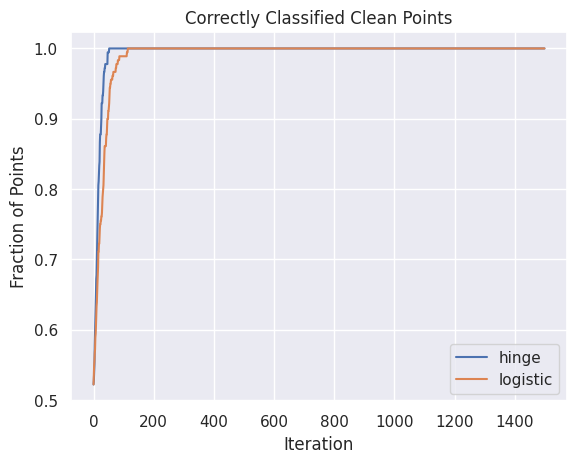

In [ ]:
hinge_vs_logistic_plot(hinge_exp_info, logistic_exp_info, data='correctly_classified_clean', normalizing_constant = num_clean)
plt.title('Correctly Classified Clean Points')
plt.ylabel('Fraction of Points')
plt.xlabel('Iteration')
plt.savefig('./drive/MyDrive/BO_data/correctly_classified_clean')

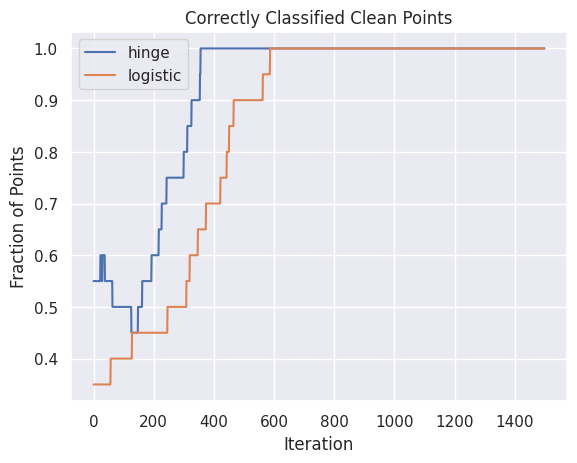

In [ ]:
hinge_vs_logistic_plot(hinge_exp_info, logistic_exp_info, data='correctly_classified_corrupt', normalizing_constant = num_corrupt)
plt.title('Correctly Classified Corrupt Points')
plt.ylabel('Fraction of Points')
plt.xlabel('Iteration')
plt.savefig('./drive/MyDrive/BO_data/correctly_classified_corrupt')

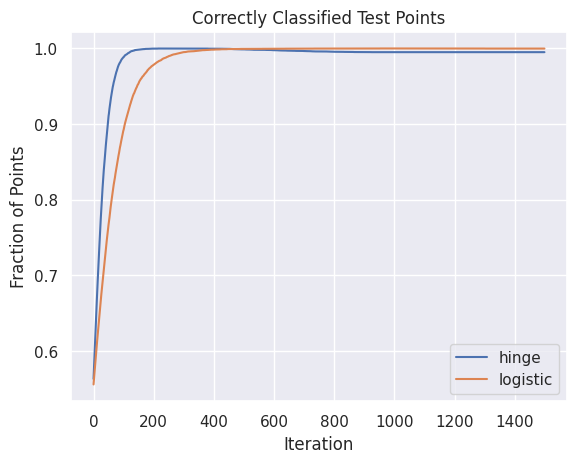

In [ ]:
hinge_vs_logistic_plot(hinge_exp_info, logistic_exp_info, data='test_correctly_classified', normalizing_constant = 20000)
plt.title('Correctly Classified Test Points')
plt.ylabel('Fraction of Points')
plt.xlabel('Iteration')
plt.savefig('./drive/MyDrive/BO_data/correctly_classified_test')

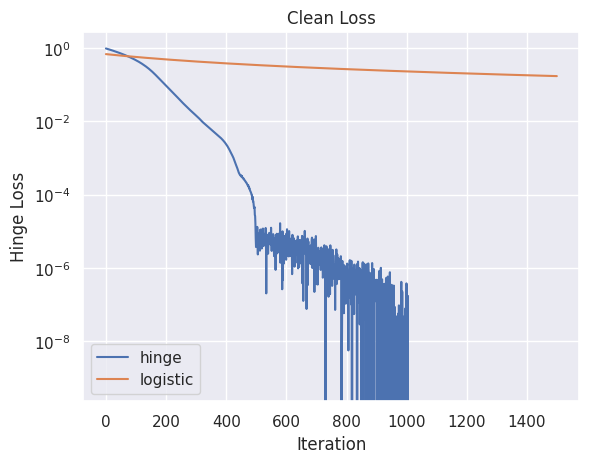

In [ ]:
hinge_vs_logistic_plot(hinge_exp_info, logistic_exp_info, data='clean_loss')
plt.yscale('log')
plt.title('Clean Loss')
plt.ylabel('Hinge Loss')
plt.xlabel('Iteration')
plt.savefig('./drive/MyDrive/BO_data/clean_loss')

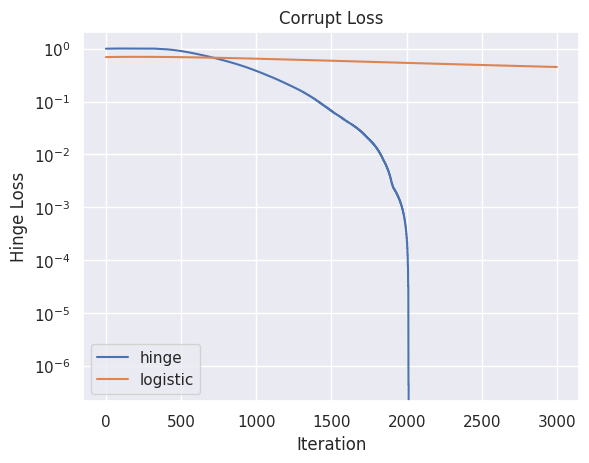

In [ ]:
hinge_vs_logistic_plot(hinge_exp_info, logistic_exp_info, data='corrupt_loss')
plt.yscale('log')
plt.title('Corrupt Loss')
plt.ylabel('Hinge Loss')
plt.xlabel('Iteration')
plt.savefig('./drive/MyDrive/BO_data/corrupt_loss')

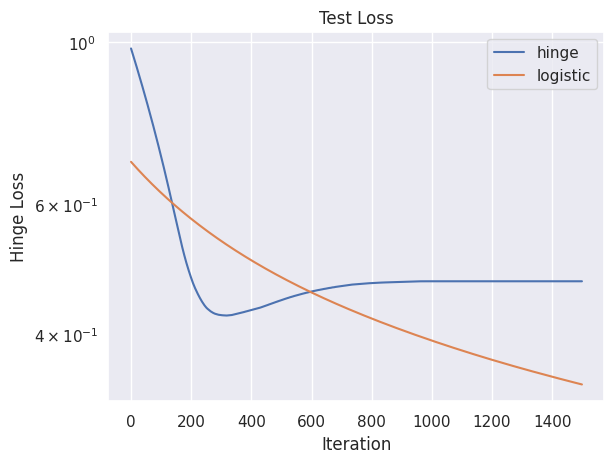

In [ ]:
hinge_vs_logistic_plot(hinge_exp_info, logistic_exp_info, data='test_losses')
plt.yscale('log')
plt.title('Test Loss')
plt.ylabel('Hinge Loss')
plt.xlabel('Iteration')
plt.savefig('./drive/MyDrive/BO_data/test_loss')

## **Heat Maps**

In [5]:
def experiment_matrix(base_cfg, gamma_vals, n_vals, corrupt_frac):

  '''Returns a 2D array first bracket indexing gamma, and second bracket indexing n'''
  matrix = [len(gamma_vals)*[None] for _ in range(len(n_vals))]

  for n_idx,n in enumerate(n_vals):
    for gamma_idx,gamma in enumerate(gamma_vals):

      cfg = copy(base_cfg)
      cfg['gamma'], cfg['n'], cfg['k'] = gamma, n, (int)(corrupt_frac * n)

      print(cfg)

      exp_data = experiment(**cfg)
      matrix[n_idx][gamma_idx] = exp_data
  return matrix

In [6]:
base_cfg = {
"input_size": 1000, #same as d
"hidden_size": 30,
"n" : None,
"gamma" : None,
"k" : None,
"step_size" : 0.005,
"epochs" : 5000,
"criterion": hinge_loss,
}

corrupt_frac = 0.05
log_gamma_vals = [-x for x in range(16)]
gamma_vals = [2**i for i in log_gamma_vals]#[2**(-x) for x in range(16)]
n_vals = range(200,19,-15)

In [ ]:
data_matrix = experiment_matrix(base_cfg, gamma_vals, n_vals, corrupt_frac)

In [ ]:
f_name = './drive/MyDrive/BO_data/data_matrix'
with open(f_name + '.pkl', 'wb') as output_file:
  pickle.dump(data_matrix, output_file)

with open(f_name+'_cfg.pkl', 'wb') as output_file:
  pickle.dump(base_cfg, output_file)

In [8]:
with open('./drive/MyDrive/BO_data/data_matrix.pkl','rb') as pickle_read:
  data_matrix = pickle.load(pickle_read)

FileNotFoundError: ignored

In [ ]:
data_matrix[0][0].keys()

dict_keys(['fully_fitted_frac', 'correctly_classified_frac', 'correctly_classified_clean_frac', 'correctly_classified_corrupt_frac', 'clean_loss', 'corrupt_loss', 'total_loss', 'test_losses', 'final_test_loss', 'test_correctly_classified_frac'])

**Clean Loss**

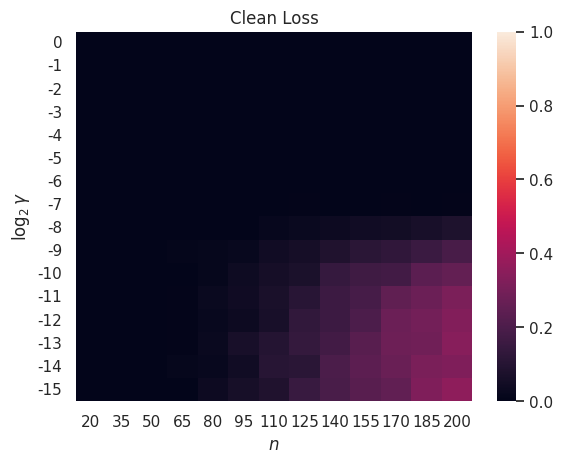

In [ ]:
datum = 'clean_loss'

heatmap = [list(map(lambda x: x[datum][-1].item(), row)) for row in data_matrix]
heatmap = [list(reversed(row)) for row in heatmap]

df_heatmap = pd.DataFrame(heatmap, index = n_vals, columns = list(reversed(log_gamma_vals)) ).T
sns.set()

ax = sns.heatmap(df_heatmap, vmin=0, vmax=1)
ax.set_xlabel(r'$n$')
ax.set_ylabel(r'$\log_2 \gamma$')
ax.invert_yaxis()
ax.invert_xaxis()

plt.title('Clean Loss')

file_name = datum + '_heat_map.png'
plt.savefig('./drive/MyDrive/BO_data/'+file_name)

**Corrupt Loss**

In [ ]:
datum = 'corrupt_loss'

heatmap = [list(map(lambda x: x[datum][-1].item()/2, row)) for row in data_matrix] #the /2 should be fixed
heatmap = [list(reversed(row)) for row in heatmap]

df_heatmap = pd.DataFrame(heatmap, index = n_vals, columns = list(reversed(log_gamma_vals)) ).T

sns.set()

ax = sns.heatmap(df_heatmap, vmin=0, vmax=1, cmap="crest")
ax.set_xlabel(r'$n$')
ax.set_ylabel(r'$\log_2 \gamma$')
ax.invert_yaxis()
ax.invert_xaxis()

plt.title('Corrupt Loss')

file_name = datum + '_heat_map.png'
plt.savefig('./drive/MyDrive/BO_data/'+file_name)

NameError: ignored

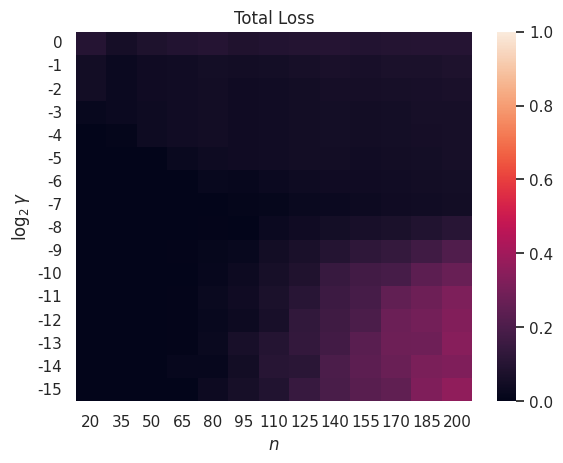

In [ ]:
datum = 'total_loss'

heatmap = [list(map(lambda x: x[datum][-1], row)) for row in data_matrix]
heatmap = [list(reversed(row)) for row in heatmap]

df_heatmap = pd.DataFrame(heatmap, index = n_vals, columns = list(reversed(log_gamma_vals)) ).T
sns.set()

ax = sns.heatmap(df_heatmap, vmin=0, vmax=1)
ax.set_xlabel(r'$n$')
ax.set_ylabel(r'$\log_2 \gamma$')
ax.invert_yaxis()
ax.invert_xaxis()

plt.title('Total Loss')

file_name = datum + '_heat_map.png'
plt.savefig('./drive/MyDrive/BO_data/'+file_name)

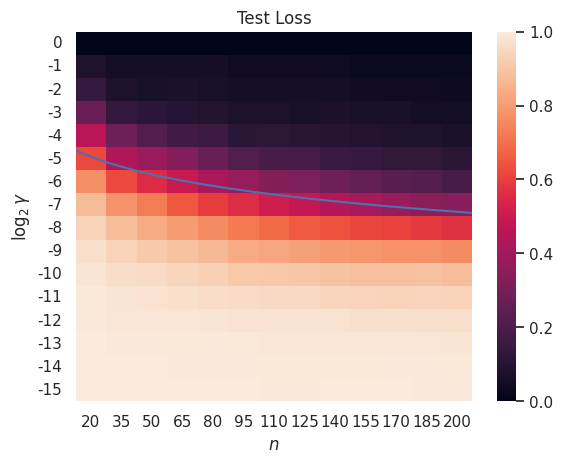

In [ ]:
datum = 'final_test_loss'

heatmap = [list(map(lambda x: x[datum], row)) for row in data_matrix]
heatmap = [list(reversed(row)) for row in heatmap]

df_heatmap = pd.DataFrame(heatmap, index = n_vals, columns = list(reversed(log_gamma_vals)) ).T
sns.set()

ax = sns.heatmap(df_heatmap, vmin=0, vmax=1)
ax.set_xlabel(r'$n$')
ax.set_ylabel(r'$\log_2 \gamma$')
ax.invert_yaxis()
ax.invert_xaxis()

ax.plot(np.linspace(0.01,13.99,100), [16+math.log(1/(20 + (14-x)*15 ), 2) for x in np.linspace(0.01,13.99,100)], color='yellow')

plt.title('Test Loss')

file_name = datum + '_heat_map.png'
plt.savefig('./drive/MyDrive/BO_data/'+file_name)